## Libraries

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import  RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# ==> NEWLY ADDED LIBRARIES FOR ADDITIONAL MODELS <==
from sklearn.ensemble import VotingClassifier, StackingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression # For ensemble models

In [35]:
# Check unique groups in the dataset
df_oasis = pd.read_csv('oasis_long_processed.csv')
print("Unique groups in 'Group' column:", df_oasis['Group'].unique())
print("Number of unique groups:", df_oasis['Group'].nunique())
print(df_oasis['Group'].value_counts())

Unique groups in 'Group' column: ['Nondemented' 'Demented' 'Converted']
Number of unique groups: 3
Group
Nondemented    190
Demented       146
Converted       37
Name: count, dtype: int64


## ML Model Results Storage Framework

In [36]:
# =============================================================================
# ML MODEL RESULTS STORAGE FRAMEWORK
# =============================================================================

# Creating holders to store the model performance results
ML_Model = []
ML_Config = []
accuracy = []
f1_score = []
recall = []
precision = []
auc_roc = []  # Adding a holder for AUC-ROC

# Function to call for storing the results
def storeResults(model, config, a, b, c, d, e):
    """
    Store model performance results
    
    Parameters:
    model: Name of the ML model
    config: Configuration name (preprocessing steps applied)
    a: Accuracy score
    b: F1 score
    c: Recall score
    d: Precision score
    e: AUC-ROC score
    """
    ML_Model.append(model)
    ML_Config.append(config)
    accuracy.append(round(a, 6))
    f1_score.append(round(b, 6))
    recall.append(round(c, 6))
    precision.append(round(d, 6))
    auc_roc.append(round(e, 6))

# Function to display and save results
def displayAndSaveResults(filename_prefix='model_results'):
    """
    Create dataframe from results, display, and save to CSV
    
    Parameters:
    filename_prefix: Prefix for the CSV filenames
    """
    # Creating the dataframe
    result = pd.DataFrame({
        'ML Model': ML_Model,
        'Configuration': ML_Config,
        'Accuracy': [f"{acc * 100:.3f}%" for acc in accuracy],
        'F1 Score': [f"{f1 * 100:.3f}%" for f1 in f1_score],
        'Recall': [f"{rec * 100:.3f}%" for rec in recall],
        'Precision': [f"{prec * 100:.3f}%" for prec in precision],
        'ROC_AUC': [f"{roc * 100:.3f}%" for roc in auc_roc],
    })
    
    # Remove duplicates if any
    result.drop_duplicates(subset=["ML Model", "Configuration"], inplace=True)
    
    print("\n" + "="*100)
    print("MODEL PERFORMANCE RESULTS")
    print("="*100)
    print(result.to_string(index=False))
    
    # Saving the result to a CSV file
    result.to_csv(f'{filename_prefix}.csv', index=False)
    print(f"\nResults saved to {filename_prefix}.csv")
    
    # Sorting the dataframe on accuracy and F1 Score
    sorted_result = result.sort_values(by=['Accuracy', 'F1 Score'], ascending=False).reset_index(drop=True)
    
    print("\n" + "="*100)
    print("SORTED MODEL PERFORMANCE RESULTS (by Accuracy and F1 Score)")
    print("="*100)
    print(sorted_result.to_string(index=False))
    
    # Saving the sorted result to a CSV file
    sorted_result.to_csv(f'sorted_{filename_prefix}.csv', index=False)
    print(f"\nSorted results saved to sorted_{filename_prefix}.csv")
    
    return result, sorted_result

# Function to clear results (useful when running multiple experiments)
def clearResults():
    """Clear all stored results"""
    global ML_Model, ML_Config, accuracy, f1_score, recall, precision, auc_roc
    ML_Model.clear()
    ML_Config.clear()
    accuracy.clear()
    f1_score.clear()
    recall.clear()
    precision.clear()
    auc_roc.clear()
    print("Results cleared!")

# Function to plot model comparison
def plotModelComparison(result_df):
    """
    Create visualization comparing model performances
    
    Parameters:
    result_df: DataFrame with model results
    """
    # Convert percentage strings back to floats for plotting
    metrics_cols = ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'ROC_AUC']
    plot_df = result_df.copy()
    
    for col in metrics_cols:
        plot_df[col] = plot_df[col].str.rstrip('%').astype(float)
    
    # Create subplot for each metric
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics_cols):
        # Group by model and get mean performance across configurations
        model_performance = plot_df.groupby('ML Model')[metric].mean().sort_values(ascending=False)
        
        # Create bar plot
        ax = axes[idx]
        bars = ax.bar(range(len(model_performance)), model_performance.values, 
                      color=plt.cm.Blues(np.linspace(0.4, 0.9, len(model_performance))))
        ax.set_xticks(range(len(model_performance)))
        ax.set_xticklabels(model_performance.index, rotation=45, ha='right')
        ax.set_ylabel(f'{metric} (%)')
        ax.set_title(f'Average {metric} by Model', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom')
    
    # Hide the last subplot if we have 5 metrics
    if len(metrics_cols) == 5:
        axes[5].set_visible(False)
    
    plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Model results storage framework loaded successfully!")

Model results storage framework loaded successfully!


## Data Loading for OASIS Dataset

In [37]:
# Import necessary libraries for preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('oasis_long_processed.csv')

# ====================================================================
#                      START: DATA PREPROCESSING
# ====================================================================

# 1. Encode the target variable 'Group' into numerical labels.
# The LabelEncoder will assign a unique integer to each class, for example:
# 'Nondemented' -> 2, 'Demented' -> 1, 'Converted' -> 0
le = LabelEncoder()
df['Group'] = le.fit_transform(df['Group'])

# 2. Separate features (X) and target (y).
# We now use the numerically encoded 'Group' column as our target.
X = df.drop('Group', axis=1)
y = df['Group']

# 3. Drop identifier columns from the features.
# These columns are unique for each scan and don't help the model generalize.
X = X.drop(['Subject ID', 'MRI ID'], axis=1)

# 4. Convert all remaining categorical columns to a numeric format.
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# ====================================================================
#                       END: DATA PREPROCESSING
# ====================================================================

# Split the fully preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- Verification ---
print("\nPreprocessed data loaded successfully!")
print("The data has been cleaned and all features are now numeric.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}\n")

print("A sample of the processed X_train data:")
print(X_train.head())


Preprocessed data loaded successfully!
The data has been cleaned and all features are now numeric.
X_train shape: (298, 21)
X_test shape: (75, 21)
y_train shape: (298,)
y_test shape: (75,)

A sample of the processed X_train data:
     Visit  MR Delay  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  ...  \
337      3      1695   81    16  3.0  30.0  0.0  1836  0.744  0.956  ...   
280      2       636   75    18  2.0  30.0  0.5  1651  0.737  1.063  ...   
311      3      1329   69    18  2.0  29.0  0.0  1202  0.770  1.461  ...   
166      1         0   69    16  2.0  28.0  0.0  1848  0.737  0.950  ...   
211      3      1752   82    11  4.0  30.0  0.0  1590  0.760  1.104  ...   

     M/F_M  CDR_Category_Moderate/Severe Dementia  CDR_Category_Normal  \
337   True                                  False                 True   
280   True                                  False                False   
311  False                                  False                 True   
166   True      

---
# SVM

### SVM with PCA 90%

In [38]:
# Store different configurations
configurations = []

# Step 1: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 2.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 2.2: RFECV
print("\n=== RFECV Feature Selection with SVM ===")
svm_estimator = SVC(kernel='linear')
rfecv = RFECV(estimator=svm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 2.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 3: SVM + GridSearchCV
print("\n=== SVM Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning SVM with {name} configuration...")
    svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    svc.fit(X_train_cfg, y_train_cfg)

    y_test_svc = svc.predict(X_test_cfg)
    y_test_svc_proba = svc.predict_proba(X_test_cfg)

    storeResults(
        'Support Vector Machine 90',
        name,
        metrics.accuracy_score(y_test, y_test_svc),
        metrics.f1_score(y_test, y_test_svc, average='macro'),
        metrics.recall_score(y_test, y_test_svc, average='macro'),
        metrics.precision_score(y_test, y_test_svc, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {svc.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with SVM ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== SVM Model Performance with Hyperparameter Tuning ===

Running SVM with Normalized Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Running SVM with SelectKBest configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Running SVM with RFECV configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for RFECV configuration stored.
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Running SVM with PCA configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for

### SVM with PCA 95%

In [39]:
# Store different configurations
configurations = []

# Step 1: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 2.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 2.2: RFECV
print("\n=== RFECV Feature Selection with SVM ===")
svm_estimator = SVC(kernel='linear')
rfecv = RFECV(estimator=svm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 2.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 3: SVM + GridSearchCV
print("\n=== SVM Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning SVM with {name} configuration...")
    svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    svc.fit(X_train_cfg, y_train_cfg)

    y_test_svc = svc.predict(X_test_cfg)
    y_test_svc_proba = svc.predict_proba(X_test_cfg)

    storeResults(
        'Support Vector Machine 95',
        name,
        metrics.accuracy_score(y_test, y_test_svc),
        metrics.f1_score(y_test, y_test_svc, average='macro'),
        metrics.recall_score(y_test, y_test_svc, average='macro'),
        metrics.precision_score(y_test, y_test_svc, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {svc.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with SVM ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== SVM Model Performance with Hyperparameter Tuning ===

Running SVM with Normalized Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Running SVM with SelectKBest configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Running SVM with RFECV configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for RFECV configuration stored.
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Running SVM with PCA configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for

### SVM with PCA 99%

In [40]:
# Store different configurations
configurations = []

# Step 1: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 2.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 2.2: RFECV
print("\n=== RFECV Feature Selection with SVM ===")
svm_estimator = SVC(kernel='linear')
rfecv = RFECV(estimator=svm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 2.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 3: SVM + GridSearchCV
print("\n=== SVM Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning SVM with {name} configuration...")
    svc = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    svc.fit(X_train_cfg, y_train_cfg)

    y_test_svc = svc.predict(X_test_cfg)
    y_test_svc_proba = svc.predict_proba(X_test_cfg)

    storeResults(
        'Support Vector Machine 99',
        name,
        metrics.accuracy_score(y_test, y_test_svc),
        metrics.f1_score(y_test, y_test_svc, average='macro'),
        metrics.recall_score(y_test, y_test_svc, average='macro'),
        metrics.precision_score(y_test, y_test_svc, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {svc.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with SVM ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== SVM Model Performance with Hyperparameter Tuning ===

Running SVM with Normalized Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Running SVM with SelectKBest configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Running SVM with RFECV configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for RFECV configuration stored.
Best hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Running SVM with PCA configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for

---
# Random Forest

### Random Forest with PCA 90%

In [41]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Random Forest ===")
rf_estimator = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Random Forest + GridSearchCV
print("\n=== Random Forest Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Random Forest with {name} configuration...")
    rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    rf.fit(X_train_cfg, y_train_cfg)

    y_test_rf = rf.predict(X_test_cfg)
    y_test_rf_proba = rf.predict_proba(X_test_cfg)

    storeResults(
        'Random Forest 90',
        name,
        metrics.accuracy_score(y_test, y_test_rf),
        metrics.f1_score(y_test, y_test_rf, average='macro'),
        metrics.recall_score(y_test, y_test_rf, average='macro'),
        metrics.precision_score(y_test, y_test_rf, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {rf.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Random Forest ===
Optimal number of features selected by RFECV: 14

=== PCA Dimensionality Reduction ===

=== Random Forest Model Performance with Hyperparameter Tuning ===

Running Random Forest with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Random Forest with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Random Forest with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configurati

### Random Forest with PCA 95%

In [42]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Random Forest ===")
rf_estimator = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Random Forest + GridSearchCV
print("\n=== Random Forest Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Random Forest with {name} configuration...")
    rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    rf.fit(X_train_cfg, y_train_cfg)

    y_test_rf = rf.predict(X_test_cfg)
    y_test_rf_proba = rf.predict_proba(X_test_cfg)

    storeResults(
        'Random Forest 95',
        name,
        metrics.accuracy_score(y_test, y_test_rf),
        metrics.f1_score(y_test, y_test_rf, average='macro'),
        metrics.recall_score(y_test, y_test_rf, average='macro'),
        metrics.precision_score(y_test, y_test_rf, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {rf.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Random Forest ===
Optimal number of features selected by RFECV: 14

=== PCA Dimensionality Reduction ===

=== Random Forest Model Performance with Hyperparameter Tuning ===

Running Random Forest with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Random Forest with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Random Forest with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configurati

### Random Forest with PCA 99%

In [43]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Random Forest ===")
rf_estimator = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Random Forest + GridSearchCV
print("\n=== Random Forest Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Random Forest with {name} configuration...")
    rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    rf.fit(X_train_cfg, y_train_cfg)

    y_test_rf = rf.predict(X_test_cfg)
    y_test_rf_proba = rf.predict_proba(X_test_cfg)

    storeResults(
        'Random Forest 99',
        name,
        metrics.accuracy_score(y_test, y_test_rf),
        metrics.f1_score(y_test, y_test_rf, average='macro'),
        metrics.recall_score(y_test, y_test_rf, average='macro'),
        metrics.precision_score(y_test, y_test_rf, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {rf.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Random Forest ===
Optimal number of features selected by RFECV: 14

=== PCA Dimensionality Reduction ===

=== Random Forest Model Performance with Hyperparameter Tuning ===

Running Random Forest with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Random Forest with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Random Forest with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configurati

---
# Gradient Boosting

### Gradient Boosting with PCA 90%

In [44]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Gradient Boosting ===")
gbc_estimator = GradientBoostingClassifier(random_state=42)
rfecv = RFECV(estimator=gbc_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Gradient Boosting + GridSearchCV
print("\n=== Gradient Boosting Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Gradient Boosting with {name} configuration...")
    gbc = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    gbc.fit(X_train_cfg, y_train_cfg)

    y_test_gbc = gbc.predict(X_test_cfg)
    y_test_gbc_proba = gbc.predict_proba(X_test_cfg)

    storeResults(
        'Gradient Boosting 90',
        name,
        metrics.accuracy_score(y_test, y_test_gbc),
        metrics.f1_score(y_test, y_test_gbc, average='macro'),
        metrics.recall_score(y_test, y_test_gbc, average='macro'),
        metrics.precision_score(y_test, y_test_gbc, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_gbc_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {gbc.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Gradient Boosting ===
Optimal number of features selected by RFECV: 15

=== PCA Dimensionality Reduction ===

=== Gradient Boosting Model Performance with Hyperparameter Tuning ===

Running Gradient Boosting with Original Data configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Original Data configuration stored.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Gradient Boosting with Normalized Data configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Gradient Boosting with SelectKBest configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Sel

### Gradient Boosting with PCA 95%

In [45]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Gradient Boosting ===")
gbc_estimator = GradientBoostingClassifier(random_state=42)
rfecv = RFECV(estimator=gbc_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Gradient Boosting + GridSearchCV
print("\n=== Gradient Boosting Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Gradient Boosting with {name} configuration...")
    gbc = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    gbc.fit(X_train_cfg, y_train_cfg)

    y_test_gbc = gbc.predict(X_test_cfg)
    y_test_gbc_proba = gbc.predict_proba(X_test_cfg)

    storeResults(
        'Gradient Boosting 95',
        name,
        metrics.accuracy_score(y_test, y_test_gbc),
        metrics.f1_score(y_test, y_test_gbc, average='macro'),
        metrics.recall_score(y_test, y_test_gbc, average='macro'),
        metrics.precision_score(y_test, y_test_gbc, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_gbc_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {gbc.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Gradient Boosting ===
Optimal number of features selected by RFECV: 15

=== PCA Dimensionality Reduction ===

=== Gradient Boosting Model Performance with Hyperparameter Tuning ===

Running Gradient Boosting with Original Data configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Original Data configuration stored.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Gradient Boosting with Normalized Data configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Gradient Boosting with SelectKBest configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Sel

### Gradient Boosting with PCA 99%

In [46]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Gradient Boosting ===")
gbc_estimator = GradientBoostingClassifier(random_state=42)
rfecv = RFECV(estimator=gbc_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Gradient Boosting + GridSearchCV
print("\n=== Gradient Boosting Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Gradient Boosting with {name} configuration...")
    gbc = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    gbc.fit(X_train_cfg, y_train_cfg)

    y_test_gbc = gbc.predict(X_test_cfg)
    y_test_gbc_proba = gbc.predict_proba(X_test_cfg)

    storeResults(
        'Gradient Boosting 99',
        name,
        metrics.accuracy_score(y_test, y_test_gbc),
        metrics.f1_score(y_test, y_test_gbc, average='macro'),
        metrics.recall_score(y_test, y_test_gbc, average='macro'),
        metrics.precision_score(y_test, y_test_gbc, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_gbc_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {gbc.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Gradient Boosting ===
Optimal number of features selected by RFECV: 15

=== PCA Dimensionality Reduction ===

=== Gradient Boosting Model Performance with Hyperparameter Tuning ===

Running Gradient Boosting with Original Data configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Original Data configuration stored.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Gradient Boosting with Normalized Data configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Running Gradient Boosting with SelectKBest configuration...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Results for Sel

---
# Adaboost

### Adaboost with PCA 90%

In [47]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with AdaBoost ===")
ab_estimator = AdaBoostClassifier(random_state=42)
rfecv = RFECV(estimator=ab_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: AdaBoost + GridSearchCV
print("\n=== AdaBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning AdaBoost with {name} configuration...")
    ab = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    ab.fit(X_train_cfg, y_train_cfg)

    y_test_ab = ab.predict(X_test_cfg)
    y_test_ab_proba = ab.predict_proba(X_test_cfg)

    storeResults(
        'AdaBoost 90',
        name,
        metrics.accuracy_score(y_test, y_test_ab),
        metrics.f1_score(y_test, y_test_ab, average='macro'),
        metrics.recall_score(y_test, y_test_ab, average='macro'),
        metrics.precision_score(y_test, y_test_ab, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_ab_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {ab.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with AdaBoost ===
Optimal number of features selected by RFECV: 2

=== PCA Dimensionality Reduction ===

=== AdaBoost Model Performance with Hyperparameter Tuning ===

Running AdaBoost with Original Data configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for Original Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50}

Running AdaBoost with Normalized Data configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 200}

Running AdaBoost with SelectKBest configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'estimator': Decision

### Adaboost with PCA 95%

In [48]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with AdaBoost ===")
ab_estimator = AdaBoostClassifier(random_state=42)
rfecv = RFECV(estimator=ab_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: AdaBoost + GridSearchCV
print("\n=== AdaBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning AdaBoost with {name} configuration...")
    ab = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    ab.fit(X_train_cfg, y_train_cfg)

    y_test_ab = ab.predict(X_test_cfg)
    y_test_ab_proba = ab.predict_proba(X_test_cfg)

    storeResults(
        'AdaBoost 95',
        name,
        metrics.accuracy_score(y_test, y_test_ab),
        metrics.f1_score(y_test, y_test_ab, average='macro'),
        metrics.recall_score(y_test, y_test_ab, average='macro'),
        metrics.precision_score(y_test, y_test_ab, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_ab_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {ab.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with AdaBoost ===
Optimal number of features selected by RFECV: 2

=== PCA Dimensionality Reduction ===

=== AdaBoost Model Performance with Hyperparameter Tuning ===

Running AdaBoost with Original Data configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for Original Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50}

Running AdaBoost with Normalized Data configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 200}

Running AdaBoost with SelectKBest configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'estimator': Decision

### Adaboost with PCA 99%

In [49]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with AdaBoost ===")
ab_estimator = AdaBoostClassifier(random_state=42)
rfecv = RFECV(estimator=ab_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: AdaBoost + GridSearchCV
print("\n=== AdaBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning AdaBoost with {name} configuration...")
    ab = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    ab.fit(X_train_cfg, y_train_cfg)

    y_test_ab = ab.predict(X_test_cfg)
    y_test_ab_proba = ab.predict_proba(X_test_cfg)

    storeResults(
        'AdaBoost 99',
        name,
        metrics.accuracy_score(y_test, y_test_ab),
        metrics.f1_score(y_test, y_test_ab, average='macro'),
        metrics.recall_score(y_test, y_test_ab, average='macro'),
        metrics.precision_score(y_test, y_test_ab, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_ab_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {ab.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with AdaBoost ===
Optimal number of features selected by RFECV: 2

=== PCA Dimensionality Reduction ===

=== AdaBoost Model Performance with Hyperparameter Tuning ===

Running AdaBoost with Original Data configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for Original Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50}

Running AdaBoost with Normalized Data configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 200}

Running AdaBoost with SelectKBest configuration...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'estimator': Decision

---
# XGBoost

### XGBoost with PCA 90%

In [50]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with XGBoost ===")
xgb_estimator = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rfecv = RFECV(estimator=xgb_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: XGBoost + GridSearchCV
print("\n=== XGBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning XGBoost with {name} configuration...")
    xgb_model = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    xgb_model.fit(X_train_cfg, y_train_cfg)

    y_test_xgb = xgb_model.predict(X_test_cfg)
    y_test_xgb_proba = xgb_model.predict_proba(X_test_cfg)

    storeResults(
        'XGBoost 90',
        name,
        metrics.accuracy_score(y_test, y_test_xgb),
        metrics.f1_score(y_test, y_test_xgb, average='macro'),
        metrics.recall_score(y_test, y_test_xgb, average='macro'),
        metrics.precision_score(y_test, y_test_xgb, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_xgb_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {xgb_model.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with XGBoost ===
Optimal number of features selected by RFECV: 13

=== PCA Dimensionality Reduction ===

=== XGBoost Model Performance with Hyperparameter Tuning ===

Running XGBoost with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Running XGBoost with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Running XGBoost with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'learn

### XGBoost with PCA 95%

In [51]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with XGBoost ===")
xgb_estimator = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rfecv = RFECV(estimator=xgb_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: XGBoost + GridSearchCV
print("\n=== XGBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning XGBoost with {name} configuration...")
    xgb_model = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    xgb_model.fit(X_train_cfg, y_train_cfg)

    y_test_xgb = xgb_model.predict(X_test_cfg)
    y_test_xgb_proba = xgb_model.predict_proba(X_test_cfg)

    storeResults(
        'XGBoost 95',
        name,
        metrics.accuracy_score(y_test, y_test_xgb),
        metrics.f1_score(y_test, y_test_xgb, average='macro'),
        metrics.recall_score(y_test, y_test_xgb, average='macro'),
        metrics.precision_score(y_test, y_test_xgb, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_xgb_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {xgb_model.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with XGBoost ===
Optimal number of features selected by RFECV: 13

=== PCA Dimensionality Reduction ===

=== XGBoost Model Performance with Hyperparameter Tuning ===

Running XGBoost with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Running XGBoost with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Running XGBoost with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'learn

### XGBoost with PCA 99%

In [52]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with XGBoost ===")
xgb_estimator = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rfecv = RFECV(estimator=xgb_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: XGBoost + GridSearchCV
print("\n=== XGBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning XGBoost with {name} configuration...")
    xgb_model = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    xgb_model.fit(X_train_cfg, y_train_cfg)

    y_test_xgb = xgb_model.predict(X_test_cfg)
    y_test_xgb_proba = xgb_model.predict_proba(X_test_cfg)

    storeResults(
        'XGBoost 99',
        name,
        metrics.accuracy_score(y_test, y_test_xgb),
        metrics.f1_score(y_test, y_test_xgb, average='macro'),
        metrics.recall_score(y_test, y_test_xgb, average='macro'),
        metrics.precision_score(y_test, y_test_xgb, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_xgb_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {xgb_model.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with XGBoost ===
Optimal number of features selected by RFECV: 13

=== PCA Dimensionality Reduction ===

=== XGBoost Model Performance with Hyperparameter Tuning ===

Running XGBoost with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Running XGBoost with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Running XGBoost with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'learn

---
# Bagging

### Bagging with PCA 90%

In [53]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Bagging (using Decision Tree) ===")
tree_estimator = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=tree_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Bagging Classifier + GridSearchCV
print("\n=== Bagging Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [3, 5, None]]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Bagging with {name} configuration...")
    bag = GridSearchCV(BaggingClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    bag.fit(X_train_cfg, y_train_cfg)

    y_test_bag = bag.predict(X_test_cfg)
    y_test_bag_proba = bag.predict_proba(X_test_cfg)

    storeResults(
        'Bagging 90',
        name,
        metrics.accuracy_score(y_test, y_test_bag),
        metrics.f1_score(y_test, y_test_bag, average='macro'),
        metrics.recall_score(y_test, y_test_bag, average='macro'),
        metrics.precision_score(y_test, y_test_bag, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_bag_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {bag.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Bagging (using Decision Tree) ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== Bagging Model Performance with Hyperparameter Tuning ===

Running Bagging with Original Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Original Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(), 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 150}

Running Bagging with Normalized Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(), 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 150}

Running Bagging with SelectKBest configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for SelectKBest configuration stored.
Best hyp

### Bagging with PCA 95%

In [54]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Bagging (using Decision Tree) ===")
tree_estimator = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=tree_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Bagging Classifier + GridSearchCV
print("\n=== Bagging Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [3, 5, None]]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Bagging with {name} configuration...")
    bag = GridSearchCV(BaggingClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    bag.fit(X_train_cfg, y_train_cfg)

    y_test_bag = bag.predict(X_test_cfg)
    y_test_bag_proba = bag.predict_proba(X_test_cfg)

    storeResults(
        'Bagging 95',
        name,
        metrics.accuracy_score(y_test, y_test_bag),
        metrics.f1_score(y_test, y_test_bag, average='macro'),
        metrics.recall_score(y_test, y_test_bag, average='macro'),
        metrics.precision_score(y_test, y_test_bag, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_bag_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {bag.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Bagging (using Decision Tree) ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== Bagging Model Performance with Hyperparameter Tuning ===

Running Bagging with Original Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Original Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(), 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 150}

Running Bagging with Normalized Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(), 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 150}

Running Bagging with SelectKBest configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for SelectKBest configuration stored.
Best hyp

### Bagging with PCA 99%

In [55]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Bagging (using Decision Tree) ===")
tree_estimator = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=tree_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Bagging Classifier + GridSearchCV
print("\n=== Bagging Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [3, 5, None]]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Bagging with {name} configuration...")
    bag = GridSearchCV(BaggingClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    bag.fit(X_train_cfg, y_train_cfg)

    y_test_bag = bag.predict(X_test_cfg)
    y_test_bag_proba = bag.predict_proba(X_test_cfg)

    storeResults(
        'Bagging 99',
        name,
        metrics.accuracy_score(y_test, y_test_bag),
        metrics.f1_score(y_test, y_test_bag, average='macro'),
        metrics.recall_score(y_test, y_test_bag, average='macro'),
        metrics.precision_score(y_test, y_test_bag, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_bag_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {bag.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Bagging (using Decision Tree) ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== Bagging Model Performance with Hyperparameter Tuning ===

Running Bagging with Original Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Original Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(), 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 150}

Running Bagging with Normalized Data configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'estimator': DecisionTreeClassifier(), 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 150}

Running Bagging with SelectKBest configuration...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results for SelectKBest configuration stored.
Best hyp

---
# Decision Tree

### Decision Tree with PCA 90%

In [56]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Decision Tree ===")
tree_estimator = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=tree_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Decision Tree + GridSearchCV
print("\n=== Decision Tree Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Decision Tree with {name} configuration...")
    dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    dt.fit(X_train_cfg, y_train_cfg)

    y_test_dt = dt.predict(X_test_cfg)
    y_test_dt_proba = dt.predict_proba(X_test_cfg)

    storeResults(
        'Decision Tree 90',
        name,
        metrics.accuracy_score(y_test, y_test_dt),
        metrics.f1_score(y_test, y_test_dt, average='macro'),
        metrics.recall_score(y_test, y_test_dt, average='macro'),
        metrics.precision_score(y_test, y_test_dt, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_dt_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {dt.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Decision Tree ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== Decision Tree Model Performance with Hyperparameter Tuning ===

Running Decision Tree with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Running Decision Tree with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Running Decision Tree with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'criterio

### Decision Tree with PCA 95%

In [57]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Decision Tree ===")
tree_estimator = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=tree_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Decision Tree + GridSearchCV
print("\n=== Decision Tree Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Decision Tree with {name} configuration...")
    dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    dt.fit(X_train_cfg, y_train_cfg)

    y_test_dt = dt.predict(X_test_cfg)
    y_test_dt_proba = dt.predict_proba(X_test_cfg)

    storeResults(
        'Decision Tree 95',
        name,
        metrics.accuracy_score(y_test, y_test_dt),
        metrics.f1_score(y_test, y_test_dt, average='macro'),
        metrics.recall_score(y_test, y_test_dt, average='macro'),
        metrics.precision_score(y_test, y_test_dt, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_dt_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {dt.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Decision Tree ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== Decision Tree Model Performance with Hyperparameter Tuning ===

Running Decision Tree with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Running Decision Tree with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Running Decision Tree with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'criterio

### Decision Tree with PCA 99%

In [58]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Decision Tree ===")
tree_estimator = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=tree_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Decision Tree + GridSearchCV
print("\n=== Decision Tree Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Decision Tree with {name} configuration...")
    dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    dt.fit(X_train_cfg, y_train_cfg)

    y_test_dt = dt.predict(X_test_cfg)
    y_test_dt_proba = dt.predict_proba(X_test_cfg)

    storeResults(
        'Decision Tree 99',
        name,
        metrics.accuracy_score(y_test, y_test_dt),
        metrics.f1_score(y_test, y_test_dt, average='macro'),
        metrics.recall_score(y_test, y_test_dt, average='macro'),
        metrics.precision_score(y_test, y_test_dt, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_dt_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {dt.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Decision Tree ===
Optimal number of features selected by RFECV: 1

=== PCA Dimensionality Reduction ===

=== Decision Tree Model Performance with Hyperparameter Tuning ===

Running Decision Tree with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Running Decision Tree with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

Running Decision Tree with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'criterio

---
# LightGBM

### LightGBM with PCA 90%

In [59]:
# # Store different configurations
# configurations = []
# # configurations.append(('Original Data', X_train, X_test, y_train))

# # Step 2: Normalize the data
# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.transform(X_test)
# configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# # Step 3.1: SelectKBest
# print("\n=== SelectKBest Feature Selection ===")
# kbest = SelectKBest(score_func=f_classif, k=10)
# X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
# X_test_kbest = kbest.transform(X_test_normalized)
# configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# # Step 3.2: RFECV
# print("\n=== RFECV Feature Selection with LightGBM ===")
# lgbm_estimator = LGBMClassifier(random_state=42)
# rfecv = RFECV(estimator=lgbm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
# rfecv.fit(X_train_normalized, y_train)
# print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
# X_train_rfe = rfecv.transform(X_train_normalized)
# X_test_rfe = rfecv.transform(X_test_normalized)
# configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# # Step 3.3: PCA
# print("\n=== PCA Dimensionality Reduction ===")
# pca = PCA(n_components=0.90)
# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)
# configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# # Step 4: LightGBM + GridSearchCV
# print("\n=== LightGBM Model Performance with Hyperparameter Tuning ===")

# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [20, 31, 40],
#     'max_depth': [-1, 5, 10]
# }

# for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
#     print(f"\nRunning LightGBM with {name} configuration...")
#     lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
#     lgbm.fit(X_train_cfg, y_train_cfg)

#     y_test_lgbm = lgbm.predict(X_test_cfg)
#     y_test_lgbm_proba = lgbm.predict_proba(X_test_cfg)

#     storeResults(
#         'LightGBM 90',
#         name,
#         metrics.accuracy_score(y_test, y_test_lgbm),
#         metrics.f1_score(y_test, y_test_lgbm, average='macro'),
#         metrics.recall_score(y_test, y_test_lgbm, average='macro'),
#         metrics.precision_score(y_test, y_test_lgbm, average='macro'),
#         metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lgbm_proba, multi_class='ovr', average='macro')
#     )
#     print(f"Results for {name} configuration stored.")
#     print(f"Best hyperparameters: {lgbm.best_params_}")

### LightGBM with PCA 95%

In [60]:
# # Store different configurations
# configurations = []
# configurations.append(('Original Data', X_train, X_test, y_train))

# # Step 2: Normalize the data
# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.transform(X_test)
# configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# # Step 3.1: SelectKBest
# print("\n=== SelectKBest Feature Selection ===")
# kbest = SelectKBest(score_func=f_classif, k=10)
# X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
# X_test_kbest = kbest.transform(X_test_normalized)
# configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# # Step 3.2: RFECV
# print("\n=== RFECV Feature Selection with LightGBM ===")
# lgbm_estimator = LGBMClassifier(random_state=42)
# rfecv = RFECV(estimator=lgbm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
# rfecv.fit(X_train_normalized, y_train)
# print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
# X_train_rfe = rfecv.transform(X_train_normalized)
# X_test_rfe = rfecv.transform(X_test_normalized)
# configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# # Step 3.3: PCA
# print("\n=== PCA Dimensionality Reduction ===")
# pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)
# configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# # Step 4: LightGBM + GridSearchCV
# print("\n=== LightGBM Model Performance with Hyperparameter Tuning ===")

# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [20, 31, 40],
#     'max_depth': [-1, 5, 10]
# }

# for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
#     print(f"\nRunning LightGBM with {name} configuration...")
#     lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
#     lgbm.fit(X_train_cfg, y_train_cfg)

#     y_test_lgbm = lgbm.predict(X_test_cfg)
#     y_test_lgbm_proba = lgbm.predict_proba(X_test_cfg)

#     storeResults(
#         'LightGBM 95',
#         name,
#         metrics.accuracy_score(y_test, y_test_lgbm),
#         metrics.f1_score(y_test, y_test_lgbm, average='macro'),
#         metrics.recall_score(y_test, y_test_lgbm, average='macro'),
#         metrics.precision_score(y_test, y_test_lgbm, average='macro'),
#         metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lgbm_proba, multi_class='ovr', average='macro')
#     )
#     print(f"Results for {name} configuration stored.")
#     print(f"Best hyperparameters: {lgbm.best_params_}")

### LightGBM with PCA 99%

In [61]:
# # Store different configurations
# configurations = []
# configurations.append(('Original Data', X_train, X_test, y_train))

# # Step 2: Normalize the data
# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.transform(X_test)
# configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# # Step 3.1: SelectKBest
# print("\n=== SelectKBest Feature Selection ===")
# kbest = SelectKBest(score_func=f_classif, k=10)
# X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
# X_test_kbest = kbest.transform(X_test_normalized)
# configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# # Step 3.2: RFECV
# print("\n=== RFECV Feature Selection with LightGBM ===")
# lgbm_estimator = LGBMClassifier(random_state=42)
# rfecv = RFECV(estimator=lgbm_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
# rfecv.fit(X_train_normalized, y_train)
# print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
# X_train_rfe = rfecv.transform(X_train_normalized)
# X_test_rfe = rfecv.transform(X_test_normalized)
# configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# # Step 3.3: PCA
# print("\n=== PCA Dimensionality Reduction ===")
# pca = PCA(n_components=0.99)
# X_train_pca = pca.fit_transform(X_train_normalized)
# X_test_pca = pca.transform(X_test_normalized)
# configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# # Step 4: LightGBM + GridSearchCV
# print("\n=== LightGBM Model Performance with Hyperparameter Tuning ===")

# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [20, 31, 40],
#     'max_depth': [-1, 5, 10]
# }

# for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
#     print(f"\nRunning LightGBM with {name} configuration...")
#     lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
#     lgbm.fit(X_train_cfg, y_train_cfg)

#     y_test_lgbm = lgbm.predict(X_test_cfg)
#     y_test_lgbm_proba = lgbm.predict_proba(X_test_cfg)

#     storeResults(
#         'LightGBM 99',
#         name,
#         metrics.accuracy_score(y_test, y_test_lgbm),
#         metrics.f1_score(y_test, y_test_lgbm, average='macro'),
#         metrics.recall_score(y_test, y_test_lgbm, average='macro'),
#         metrics.precision_score(y_test, y_test_lgbm, average='macro'),
#         metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lgbm_proba, multi_class='ovr', average='macro')
#     )
#     print(f"Results for {name} configuration stored.")
#     print(f"Best hyperparameters: {lgbm.best_params_}")

---
# Extra Trees

### Extra Trees with PCA 90%

In [62]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Extra Trees ===")
et_estimator = ExtraTreesClassifier(random_state=42)
rfecv = RFECV(estimator=et_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Extra Trees + GridSearchCV
print("\n=== Extra Trees Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Extra Trees with {name} configuration...")
    et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    et.fit(X_train_cfg, y_train_cfg)

    y_test_et = et.predict(X_test_cfg)
    y_test_et_proba = et.predict_proba(X_test_cfg)

    storeResults(
        'Extra Trees 90',
        name,
        metrics.accuracy_score(y_test, y_test_et),
        metrics.f1_score(y_test, y_test_et, average='macro'),
        metrics.recall_score(y_test, y_test_et, average='macro'),
        metrics.precision_score(y_test, y_test_et, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_et_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {et.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Extra Trees ===
Optimal number of features selected by RFECV: 16

=== PCA Dimensionality Reduction ===

=== Extra Trees Model Performance with Hyperparameter Tuning ===

Running Extra Trees with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Running Extra Trees with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Running Extra Trees with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.

### Extra Trees with PCA 95%

In [63]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Extra Trees ===")
et_estimator = ExtraTreesClassifier(random_state=42)
rfecv = RFECV(estimator=et_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Extra Trees + GridSearchCV
print("\n=== Extra Trees Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Extra Trees with {name} configuration...")
    et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    et.fit(X_train_cfg, y_train_cfg)

    y_test_et = et.predict(X_test_cfg)
    y_test_et_proba = et.predict_proba(X_test_cfg)

    storeResults(
        'Extra Trees 95',
        name,
        metrics.accuracy_score(y_test, y_test_et),
        metrics.f1_score(y_test, y_test_et, average='macro'),
        metrics.recall_score(y_test, y_test_et, average='macro'),
        metrics.precision_score(y_test, y_test_et, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_et_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {et.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Extra Trees ===
Optimal number of features selected by RFECV: 16

=== PCA Dimensionality Reduction ===

=== Extra Trees Model Performance with Hyperparameter Tuning ===

Running Extra Trees with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Running Extra Trees with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Running Extra Trees with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.

### Extra Trees with PCA 99%

In [64]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with Extra Trees ===")
et_estimator = ExtraTreesClassifier(random_state=42)
rfecv = RFECV(estimator=et_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Extra Trees + GridSearchCV
print("\n=== Extra Trees Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Extra Trees with {name} configuration...")
    et = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
    et.fit(X_train_cfg, y_train_cfg)

    y_test_et = et.predict(X_test_cfg)
    y_test_et_proba = et.predict_proba(X_test_cfg)

    storeResults(
        'Extra Trees 99',
        name,
        metrics.accuracy_score(y_test, y_test_et),
        metrics.f1_score(y_test, y_test_et, average='macro'),
        metrics.recall_score(y_test, y_test_et, average='macro'),
        metrics.precision_score(y_test, y_test_et, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_et_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {et.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with Extra Trees ===
Optimal number of features selected by RFECV: 16

=== PCA Dimensionality Reduction ===

=== Extra Trees Model Performance with Hyperparameter Tuning ===

Running Extra Trees with Original Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Original Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Running Extra Trees with Normalized Data configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Running Extra Trees with SelectKBest configuration...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for SelectKBest configuration stored.

---
# CatBoost

> **Note:** CatBoost can be slow with GridSearchCV. The parameter grid below is kept small to ensure it runs in a reasonable amount of time.

### CatBoost with PCA 90%

In [65]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with CatBoost ===")
cat_estimator = CatBoostClassifier(random_state=42, verbose=0)
rfecv = RFECV(estimator=cat_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: CatBoost + GridSearchCV
print("\n=== CatBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning CatBoost with {name} configuration...")
    cat = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid, cv=5, n_jobs=-1, verbose=1)
    cat.fit(X_train_cfg, y_train_cfg)

    y_test_cat = cat.predict(X_test_cfg)
    y_test_cat_proba = cat.predict_proba(X_test_cfg)

    storeResults(
        'CatBoost 90',
        name,
        metrics.accuracy_score(y_test, y_test_cat),
        metrics.f1_score(y_test, y_test_cat, average='macro'),
        metrics.recall_score(y_test, y_test_cat, average='macro'),
        metrics.precision_score(y_test, y_test_cat, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_cat_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {cat.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with CatBoost ===
Optimal number of features selected by RFECV: 17

=== PCA Dimensionality Reduction ===

=== CatBoost Model Performance with Hyperparameter Tuning ===

Running CatBoost with Original Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Original Data configuration stored.
Best hyperparameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Running CatBoost with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Running CatBoost with SelectKBest configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

Running CatBoost with RFECV configuration...
Fitt

### CatBoost with PCA 95%

In [66]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with CatBoost ===")
cat_estimator = CatBoostClassifier(random_state=42, verbose=0)
rfecv = RFECV(estimator=cat_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: CatBoost + GridSearchCV
print("\n=== CatBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning CatBoost with {name} configuration...")
    cat = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid, cv=5, n_jobs=-1, verbose=1)
    cat.fit(X_train_cfg, y_train_cfg)

    y_test_cat = cat.predict(X_test_cfg)
    y_test_cat_proba = cat.predict_proba(X_test_cfg)

    storeResults(
        'CatBoost 95',
        name,
        metrics.accuracy_score(y_test, y_test_cat),
        metrics.f1_score(y_test, y_test_cat, average='macro'),
        metrics.recall_score(y_test, y_test_cat, average='macro'),
        metrics.precision_score(y_test, y_test_cat, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_cat_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {cat.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with CatBoost ===
Optimal number of features selected by RFECV: 17

=== PCA Dimensionality Reduction ===

=== CatBoost Model Performance with Hyperparameter Tuning ===

Running CatBoost with Original Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Original Data configuration stored.
Best hyperparameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Running CatBoost with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Running CatBoost with SelectKBest configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

Running CatBoost with RFECV configuration...
Fitt

### CatBoost with PCA 99%

In [67]:
# Store different configurations
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# Step 3.1: SelectKBest
print("\n=== SelectKBest Feature Selection ===")
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train_normalized, y_train)
X_test_kbest = kbest.transform(X_test_normalized)
configurations.append(('SelectKBest', X_train_kbest, X_test_kbest, y_train))

# Step 3.2: RFECV
print("\n=== RFECV Feature Selection with CatBoost ===")
cat_estimator = CatBoostClassifier(random_state=42, verbose=0)
rfecv = RFECV(estimator=cat_estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)
print(f"Optimal number of features selected by RFECV: {rfecv.n_features_}")
X_train_rfe = rfecv.transform(X_train_normalized)
X_test_rfe = rfecv.transform(X_test_normalized)
configurations.append(('RFECV', X_train_rfe, X_test_rfe, y_train))

# Step 3.3: PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: CatBoost + GridSearchCV
print("\n=== CatBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning CatBoost with {name} configuration...")
    cat = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid, cv=5, n_jobs=-1, verbose=1)
    cat.fit(X_train_cfg, y_train_cfg)

    y_test_cat = cat.predict(X_test_cfg)
    y_test_cat_proba = cat.predict_proba(X_test_cfg)

    storeResults(
        'CatBoost 99',
        name,
        metrics.accuracy_score(y_test, y_test_cat),
        metrics.f1_score(y_test, y_test_cat, average='macro'),
        metrics.recall_score(y_test, y_test_cat, average='macro'),
        metrics.precision_score(y_test, y_test_cat, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_cat_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {cat.best_params_}")


=== SelectKBest Feature Selection ===

=== RFECV Feature Selection with CatBoost ===
Optimal number of features selected by RFECV: 17

=== PCA Dimensionality Reduction ===

=== CatBoost Model Performance with Hyperparameter Tuning ===

Running CatBoost with Original Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Original Data configuration stored.
Best hyperparameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Running CatBoost with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Running CatBoost with SelectKBest configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for SelectKBest configuration stored.
Best hyperparameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

Running CatBoost with RFECV configuration...
Fitt

---
# Voting Classifier

### Voting Classifier with PCA 90%

In [68]:
# Define base estimators
clf1 = LogisticRegression(random_state=42, multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=42)
clf3 = SVC(probability=True, random_state=42)

# Create the Voting Classifier
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')

# Store different configurations
configurations = []
# NOTE: Voting Classifier performs best on normalized data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Voting Classifier + GridSearchCV
print("\n=== Voting Classifier Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'lr__C': [1.0, 10.0],
    'rf__n_estimators': [100, 200],
    'svc__C': [1, 10]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Voting Classifier with {name} configuration...")
    vote = GridSearchCV(estimator=eclf1, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    vote.fit(X_train_cfg, y_train_cfg)

    y_test_vote = vote.predict(X_test_cfg)
    y_test_vote_proba = vote.predict_proba(X_test_cfg)

    storeResults(
        'Voting Classifier 90',
        name,
        metrics.accuracy_score(y_test, y_test_vote),
        metrics.f1_score(y_test, y_test_vote, average='macro'),
        metrics.recall_score(y_test, y_test_vote, average='macro'),
        metrics.precision_score(y_test, y_test_vote, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_vote_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {vote.best_params_}")


=== PCA Dimensionality Reduction ===

=== Voting Classifier Model Performance with Hyperparameter Tuning ===

Running Voting Classifier with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'lr__C': 1.0, 'rf__n_estimators': 100, 'svc__C': 10}

Running Voting Classifier with PCA configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for PCA configuration stored.
Best hyperparameters: {'lr__C': 1.0, 'rf__n_estimators': 200, 'svc__C': 10}


### Voting Classifier with PCA 95%

In [69]:
# Define base estimators
clf1 = LogisticRegression(random_state=42, multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=42)
clf3 = SVC(probability=True, random_state=42)

# Create the Voting Classifier
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')

# Store different configurations
configurations = []
# NOTE: Voting Classifier performs best on normalized data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Voting Classifier + GridSearchCV
print("\n=== Voting Classifier Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'lr__C': [1.0, 10.0],
    'rf__n_estimators': [100, 200],
    'svc__C': [1, 10]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Voting Classifier with {name} configuration...")
    vote = GridSearchCV(estimator=eclf1, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    vote.fit(X_train_cfg, y_train_cfg)

    y_test_vote = vote.predict(X_test_cfg)
    y_test_vote_proba = vote.predict_proba(X_test_cfg)

    storeResults(
        'Voting Classifier 95',
        name,
        metrics.accuracy_score(y_test, y_test_vote),
        metrics.f1_score(y_test, y_test_vote, average='macro'),
        metrics.recall_score(y_test, y_test_vote, average='macro'),
        metrics.precision_score(y_test, y_test_vote, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_vote_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {vote.best_params_}")


=== PCA Dimensionality Reduction ===

=== Voting Classifier Model Performance with Hyperparameter Tuning ===

Running Voting Classifier with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'lr__C': 1.0, 'rf__n_estimators': 100, 'svc__C': 10}

Running Voting Classifier with PCA configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for PCA configuration stored.
Best hyperparameters: {'lr__C': 10.0, 'rf__n_estimators': 100, 'svc__C': 10}


### Voting Classifier with PCA 99%

In [70]:
# Define base estimators
clf1 = LogisticRegression(random_state=42, multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=42)
clf3 = SVC(probability=True, random_state=42)

# Create the Voting Classifier
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')

# Store different configurations
configurations = []
# NOTE: Voting Classifier performs best on normalized data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Voting Classifier + GridSearchCV
print("\n=== Voting Classifier Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'lr__C': [1.0, 10.0],
    'rf__n_estimators': [100, 200],
    'svc__C': [1, 10]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Voting Classifier with {name} configuration...")
    vote = GridSearchCV(estimator=eclf1, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    vote.fit(X_train_cfg, y_train_cfg)

    y_test_vote = vote.predict(X_test_cfg)
    y_test_vote_proba = vote.predict_proba(X_test_cfg)

    storeResults(
        'Voting Classifier 99',
        name,
        metrics.accuracy_score(y_test, y_test_vote),
        metrics.f1_score(y_test, y_test_vote, average='macro'),
        metrics.recall_score(y_test, y_test_vote, average='macro'),
        metrics.precision_score(y_test, y_test_vote, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_vote_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {vote.best_params_}")


=== PCA Dimensionality Reduction ===

=== Voting Classifier Model Performance with Hyperparameter Tuning ===

Running Voting Classifier with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'lr__C': 1.0, 'rf__n_estimators': 100, 'svc__C': 10}

Running Voting Classifier with PCA configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for PCA configuration stored.
Best hyperparameters: {'lr__C': 10.0, 'rf__n_estimators': 100, 'svc__C': 10}


---
# Stacking Classifier

### Stacking Classifier with PCA 90%

In [71]:
# Define base estimators
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Create the Stacking Classifier
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Store different configurations
configurations = []
# NOTE: Stacking performs best on normalized data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Stacking Classifier + GridSearchCV
print("\n=== Stacking Classifier Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'rf__max_depth': [5, 10],
    'gb__learning_rate': [0.05, 0.1],
    'final_estimator__C': [0.1, 1.0]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Stacking Classifier with {name} configuration...")
    gscv = GridSearchCV(estimator=stack, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    gscv.fit(X_train_cfg, y_train_cfg)

    y_test_stack = gscv.predict(X_test_cfg)
    y_test_stack_proba = gscv.predict_proba(X_test_cfg)

    storeResults(
        'Stacking Classifier 90',
        name,
        metrics.accuracy_score(y_test, y_test_stack),
        metrics.f1_score(y_test, y_test_stack, average='macro'),
        metrics.recall_score(y_test, y_test_stack, average='macro'),
        metrics.precision_score(y_test, y_test_stack, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_stack_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {gscv.best_params_}")


=== PCA Dimensionality Reduction ===

=== Stacking Classifier Model Performance with Hyperparameter Tuning ===

Running Stacking Classifier with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'final_estimator__C': 1.0, 'gb__learning_rate': 0.1, 'rf__max_depth': 10}

Running Stacking Classifier with PCA configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for PCA configuration stored.
Best hyperparameters: {'final_estimator__C': 1.0, 'gb__learning_rate': 0.1, 'rf__max_depth': 5}


### Stacking Classifier with PCA 95%

In [72]:
# Define base estimators
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Create the Stacking Classifier
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Store different configurations
configurations = []
# NOTE: Stacking performs best on normalized data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Stacking Classifier + GridSearchCV
print("\n=== Stacking Classifier Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'rf__max_depth': [5, 10],
    'gb__learning_rate': [0.05, 0.1],
    'final_estimator__C': [0.1, 1.0]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Stacking Classifier with {name} configuration...")
    gscv = GridSearchCV(estimator=stack, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    gscv.fit(X_train_cfg, y_train_cfg)

    y_test_stack = gscv.predict(X_test_cfg)
    y_test_stack_proba = gscv.predict_proba(X_test_cfg)

    storeResults(
        'Stacking Classifier 95',
        name,
        metrics.accuracy_score(y_test, y_test_stack),
        metrics.f1_score(y_test, y_test_stack, average='macro'),
        metrics.recall_score(y_test, y_test_stack, average='macro'),
        metrics.precision_score(y_test, y_test_stack, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_stack_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {gscv.best_params_}")


=== PCA Dimensionality Reduction ===

=== Stacking Classifier Model Performance with Hyperparameter Tuning ===

Running Stacking Classifier with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'final_estimator__C': 1.0, 'gb__learning_rate': 0.1, 'rf__max_depth': 10}

Running Stacking Classifier with PCA configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for PCA configuration stored.
Best hyperparameters: {'final_estimator__C': 1.0, 'gb__learning_rate': 0.05, 'rf__max_depth': 10}


### Stacking Classifier with PCA 99%

In [73]:
# Define base estimators
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Create the Stacking Classifier
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Store different configurations
configurations = []
# NOTE: Stacking performs best on normalized data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))

# PCA
print("\n=== PCA Dimensionality Reduction ===")
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)
configurations.append(('PCA', X_train_pca, X_test_pca, y_train))

# Step 4: Stacking Classifier + GridSearchCV
print("\n=== Stacking Classifier Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'rf__max_depth': [5, 10],
    'gb__learning_rate': [0.05, 0.1],
    'final_estimator__C': [0.1, 1.0]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Stacking Classifier with {name} configuration...")
    gscv = GridSearchCV(estimator=stack, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    gscv.fit(X_train_cfg, y_train_cfg)

    y_test_stack = gscv.predict(X_test_cfg)
    y_test_stack_proba = gscv.predict_proba(X_test_cfg)

    storeResults(
        'Stacking Classifier 99',
        name,
        metrics.accuracy_score(y_test, y_test_stack),
        metrics.f1_score(y_test, y_test_stack, average='macro'),
        metrics.recall_score(y_test, y_test_stack, average='macro'),
        metrics.precision_score(y_test, y_test_stack, average='macro'),
        metrics.roc_auc_score(pd.get_dummies(y_test), y_test_stack_proba, multi_class='ovr', average='macro')
    )
    print(f"Results for {name} configuration stored.")
    print(f"Best hyperparameters: {gscv.best_params_}")


=== PCA Dimensionality Reduction ===

=== Stacking Classifier Model Performance with Hyperparameter Tuning ===

Running Stacking Classifier with Normalized Data configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for Normalized Data configuration stored.
Best hyperparameters: {'final_estimator__C': 1.0, 'gb__learning_rate': 0.1, 'rf__max_depth': 10}

Running Stacking Classifier with PCA configuration...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Results for PCA configuration stored.
Best hyperparameters: {'final_estimator__C': 1.0, 'gb__learning_rate': 0.05, 'rf__max_depth': 5}


---
# Results


MODEL PERFORMANCE RESULTS
                 ML Model   Configuration Accuracy F1 Score  Recall Precision ROC_AUC
Support Vector Machine 90 Normalized Data  92.000%  77.377% 75.000%   95.013% 92.394%
Support Vector Machine 90     SelectKBest  89.333%  69.581% 69.684%   77.235% 89.989%
Support Vector Machine 90           RFECV  89.333%  62.970% 66.667%   59.666% 79.030%
Support Vector Machine 90             PCA  89.333%  62.970% 66.667%   59.666% 90.228%
Support Vector Machine 95 Normalized Data  92.000%  77.377% 75.000%   95.013% 92.394%
Support Vector Machine 95     SelectKBest  89.333%  69.581% 69.684%   77.235% 89.989%
Support Vector Machine 95           RFECV  89.333%  62.970% 66.667%   59.666% 79.030%
Support Vector Machine 95             PCA  89.333%  69.581% 69.684%   77.235% 92.377%
Support Vector Machine 99 Normalized Data  92.000%  77.377% 75.000%   95.013% 92.394%
Support Vector Machine 99     SelectKBest  89.333%  69.581% 69.684%   77.235% 89.989%
Support Vector Machine 99  

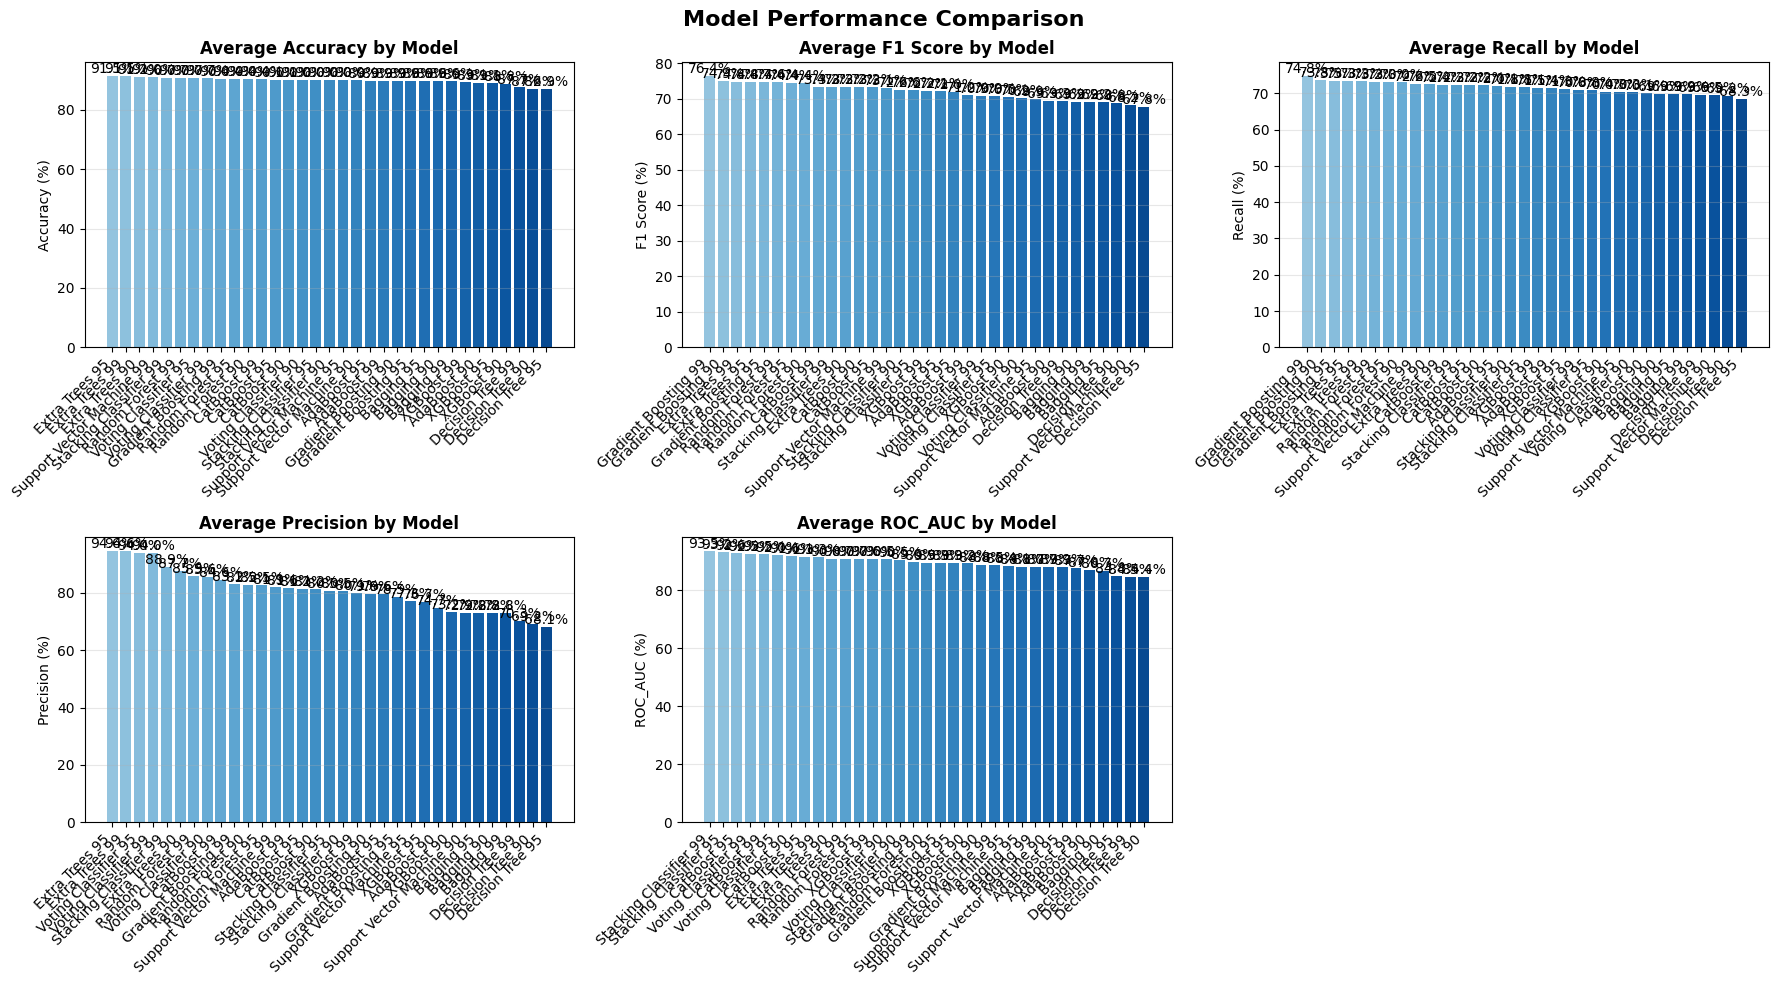

In [74]:
result, sorted_result = displayAndSaveResults(filename_prefix='oasis_model_results')

# Plot the model comparison
if not result.empty:
    plotModelComparison(result)

In [ ]:
# Creating the dataframe
result = pd.DataFrame({
    'ML Model': ML_Model,
    'Configuration': ML_Config,
    'Accuracy': [f"{acc * 100:.3f}%" for acc in accuracy],
    'F1 Score': [f"{f1 * 100:.3f}%" for f1 in f1_score],
    'Recall': [f"{rec * 100:.3f}%" for rec in recall],
    'Precision': [f"{prec * 100:.3f}%" for prec in precision],
    'ROC_AUC': [f"{roc * 100:.3f}%" for roc in auc_roc],
})

# Remove duplicates based on model and configuration
result.drop_duplicates(subset=["ML Model", "Configuration"], inplace=True)

# Display the result
print("\n" + "=" * 100)
print("MODEL PERFORMANCE RESULTS")
print("=" * 100)
print(result.to_string(index=False))

# Save the result to a CSV file
result.to_csv('results/model_results.csv', index=False)
print("\nResults saved to model_results.csv")

# Sort by Accuracy and F1 Score
sorted_result = result.sort_values(by=['F1 Score', 'Accuracy'], ascending=False).reset_index(drop=True)

# Display the sorted result
print("\n" + "=" * 100)
print("SORTED MODEL PERFORMANCE RESULTS (by Accuracy and F1 Score)")
print("=" * 100)
print(sorted_result.to_string(index=False))

# Save the sorted result
sorted_result.to_csv('results/sorted_model_results.csv', index=False)
print("\nSorted results saved to sorted_model_results.csv")

# Extract top configuration per ML model
top_per_model = sorted_result.groupby('ML Model', as_index=False).first()

# Display and save the top configuration table
print("\n" + "=" * 100)
print("TOP CONFIGURATION PER MODEL")
print("=" * 100)
print(top_per_model.to_string(index=False))

top_per_model.to_csv('results/top_configurations.csv', index=False)
print("\nTop configuration per model saved to top_configurations.csv")


MODEL PERFORMANCE RESULTS
                 ML Model   Configuration Accuracy F1 Score  Recall Precision ROC_AUC
Support Vector Machine 90 Normalized Data  92.000%  77.377% 75.000%   95.013% 92.394%
Support Vector Machine 90     SelectKBest  89.333%  69.581% 69.684%   77.235% 89.989%
Support Vector Machine 90           RFECV  89.333%  62.970% 66.667%   59.666% 79.030%
Support Vector Machine 90             PCA  89.333%  62.970% 66.667%   59.666% 90.228%
Support Vector Machine 95 Normalized Data  92.000%  77.377% 75.000%   95.013% 92.394%
Support Vector Machine 95     SelectKBest  89.333%  69.581% 69.684%   77.235% 89.989%
Support Vector Machine 95           RFECV  89.333%  62.970% 66.667%   59.666% 79.030%
Support Vector Machine 95             PCA  89.333%  69.581% 69.684%   77.235% 92.377%
Support Vector Machine 99 Normalized Data  92.000%  77.377% 75.000%   95.013% 92.394%
Support Vector Machine 99     SelectKBest  89.333%  69.581% 69.684%   77.235% 89.989%
Support Vector Machine 99  

In [ ]:
import pandas as pd

# Read input CSV
df = pd.read_csv('results/top_configurations.csv')

# Sort by 'Accuracy' column in descending order
df_sorted = df.sort_values(by=['F1 Score', 'Accuracy'], ascending=False)

# Save the sorted DataFrame to a new CSV
df_sorted.to_csv('results/sorted_top_configurations.csv', index=False)

---
# END